In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

import sklearn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import class_weight

import IvysaurusModel_VGG
import FileHelper

In [2]:
dimensions = 24
nClasses = 5

In [4]:
startGridU_calo_test = np.empty((0, dimensions, dimensions, 1))
startGridV_calo_test = np.empty((0, dimensions, dimensions, 1))
startGridW_calo_test = np.empty((0, dimensions, dimensions, 1))

endGridU_calo_test = np.empty((0, dimensions, dimensions, 1))
endGridV_calo_test = np.empty((0, dimensions, dimensions, 1))
endGridW_calo_test = np.empty((0, dimensions, dimensions, 1))

y_test = np.empty((0, nClasses))

trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/*/ivysaurus_*.npz')
print(trainFileNames)

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)
    
    startGridU_calo_test = np.concatenate((startGridU_calo_test, data['startGridU_calo_test']), axis=0)
    startGridV_calo_test = np.concatenate((startGridV_calo_test, data['startGridV_calo_test']), axis=0) 
    startGridW_calo_test = np.concatenate((startGridW_calo_test, data['startGridW_calo_test']), axis=0)
    
    endGridU_calo_test = np.concatenate((endGridU_calo_test, data['endGridU_calo_test']), axis=0)
    endGridV_calo_test = np.concatenate((endGridV_calo_test, data['endGridV_calo_test']), axis=0)
    endGridW_calo_test = np.concatenate((endGridW_calo_test, data['endGridW_calo_test']), axis=0)

    y_test = np.concatenate((y_test, data['y_test']), axis=0)

['/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nutau/ivysaurus_nutau_0.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nutau/ivysaurus_nutau_1.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nutau/ivysaurus_nutau_3.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nutau/ivysaurus_nutau_2.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_2.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_3.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_1.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_0.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_4.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nu/ivysaurus_nu_5.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nue/ivysaurus_nue_5.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gaussian/nue/ivysaurus_nue_4.npz', '/Users/isobel/Desktop/DUNE/Ivysaurus/files/gau

In [5]:
print('startGridU_calo_test: ', startGridU_calo_test.shape)
print('startGridV_calo_test: ', startGridV_calo_test.shape)
print('startGridW_calo_test: ', startGridW_calo_test.shape)
   
print('endGridU_calo_test: ', endGridU_calo_test.shape)     
print('endGridV_calo_test: ', endGridV_calo_test.shape)     
print('endGridW_calo_test: ', endGridW_calo_test.shape) 

print('y_test', y_test.shape)

startGridU_calo_test:  (179513, 24, 24, 1)
startGridV_calo_test:  (179513, 24, 24, 1)
startGridW_calo_test:  (179513, 24, 24, 1)
endGridU_calo_test:  (179513, 24, 24, 1)
endGridV_calo_test:  (179513, 24, 24, 1)
endGridW_calo_test:  (179513, 24, 24, 1)
y_test (179513, 5)


In [6]:
# load model
ivysaurus_calo_CNN = keras.models.load_model('/Users/isobel/Desktop/DUNE/Ivysaurus/IvysaurusCaloDisp/models/my_model_calo_VGG')

# Check its architecture
#ivysaurusCNN.summary()

print("Loaded model from disk")


Loaded model from disk


In [8]:
# Use the network to predict the category of the test sample

y_pred = ivysaurus_calo_CNN.predict([startGridU_calo_test, endGridU_calo_test, startGridV_calo_test, endGridV_calo_test, startGridW_calo_test, endGridW_calo_test])


5610/5610 [==============================] - 90s 16ms/step


trueSums:  [20938 55058 44747 18911 39859]
predSums:  [23943 52710 43687 20737 38436]
[[18049   118  2623    45   103]
 [  656 51116  2977    58   251]
 [ 5147  1313 37191   202   894]
 [   29    30   211 15486  3155]
 [   62   133   685  4946 34033]]


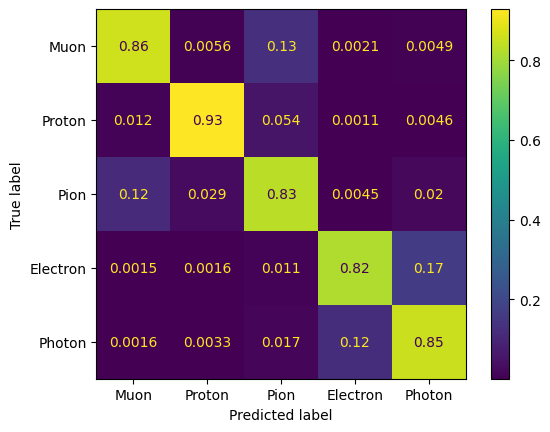

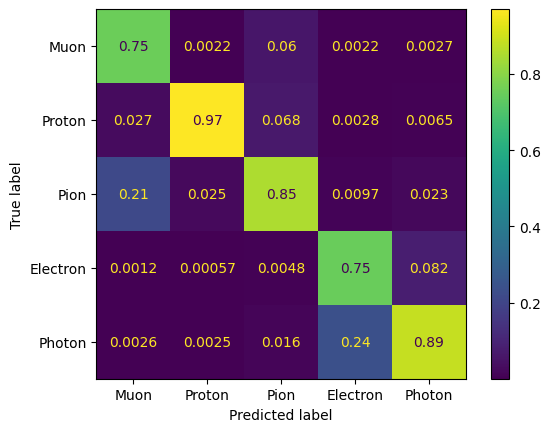

In [9]:
# Let's look at the confusion matrix

confMatrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

trueSums = np.sum(confMatrix, axis=1)
predSums = np.sum(confMatrix, axis=0)

print('trueSums: ', trueSums)
print('predSums: ', predSums)

trueNormalised = np.zeros(shape=(nClasses, nClasses))
predNormalised = np.zeros(shape=(nClasses, nClasses))

for trueIndex in range(nClasses) : 
    for predIndex in range(nClasses) :
        nEntries = confMatrix[trueIndex][predIndex]
        if trueSums[trueIndex] > 0 :
            trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
        if predSums[predIndex] > 0 :
            predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon"])
displayTrueNorm.plot()

displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["Muon", "Proton", "Pion", "Electron", "Photon"])
displayPredNorm.plot()

print(confMatrix)

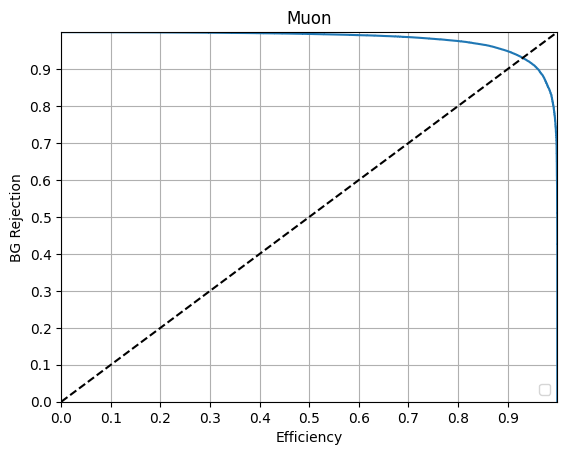

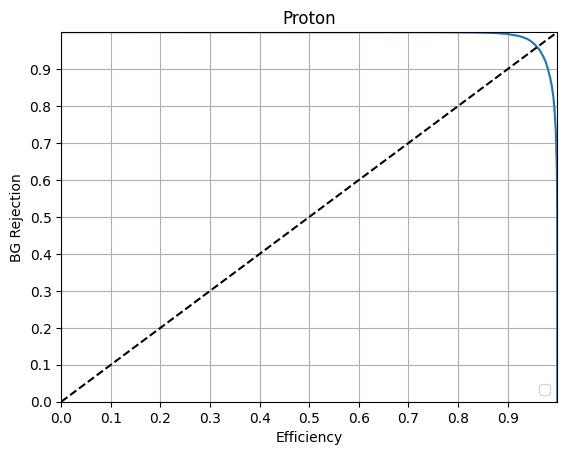

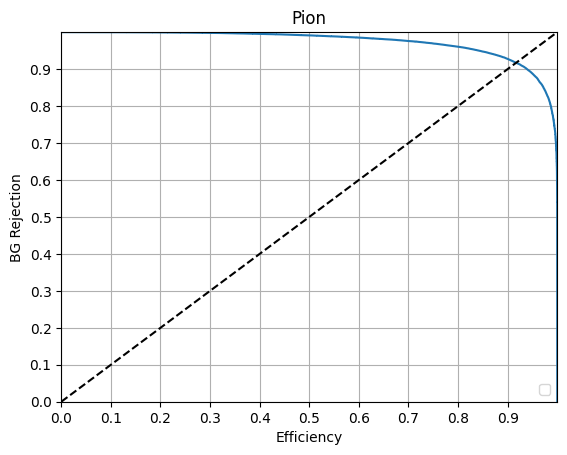

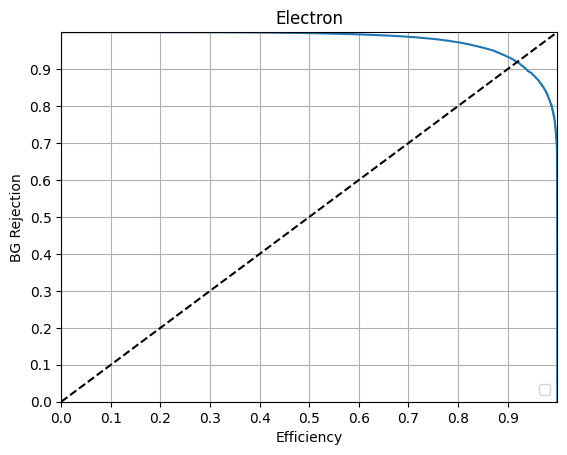

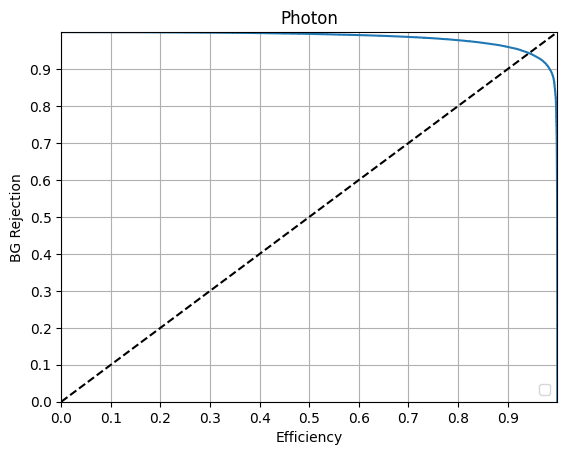

In [10]:
# Compute ROC curve and ROC area for each class

falsePositive = dict()
bkgRejection = dict()
truePositive = dict()
roc = dict()

for i in range(nClasses):
    falsePositive[i], truePositive[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    bkgRejection[i] = 1 - falsePositive[i]
    roc[i] = sklearn.metrics.auc(falsePositive[i], bkgRejection[i])

# Plot of a ROC curve for a specific class

rocCurveTitles = ["Muon", "Proton", "Pion", "Electron", "Photon", "Other"]

for i in range(nClasses):
    plt.figure()
    plt.plot(truePositive[i], bkgRejection[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.arange(0, 1, 0.1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.xlabel('Efficiency')
    plt.ylabel('BG Rejection')
    plt.title(rocCurveTitles[i])
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

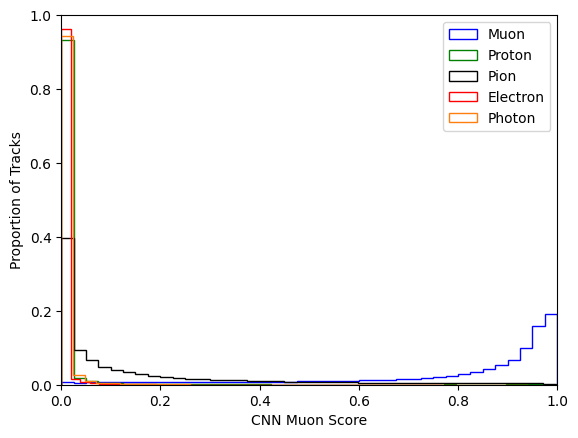

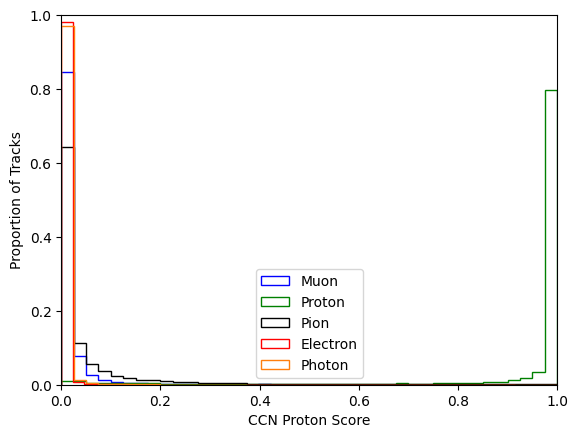

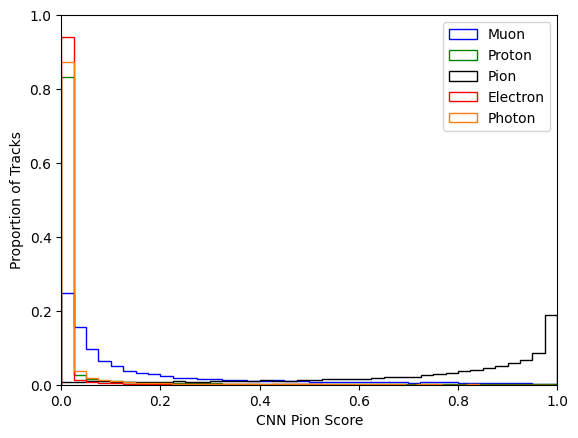

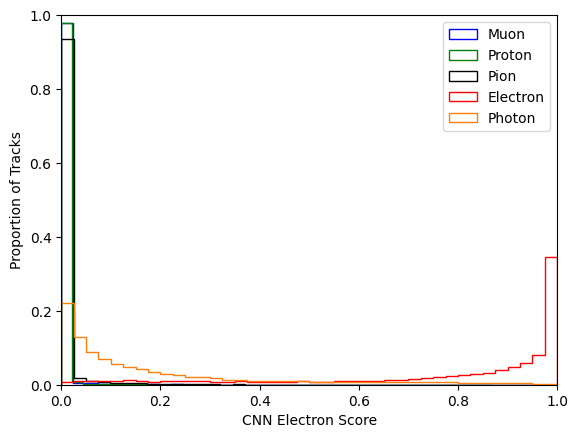

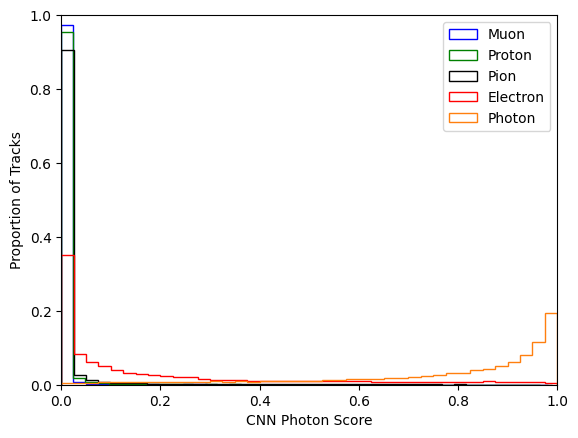

In [11]:
particleColors = ('b', 'g', 'k', 'r', 'tab:orange', 'tab:gray')
histTitles = ('CNN Muon Score', 'CCN Proton Score', 'CNN Pion Score', 'CNN Electron Score', 'CNN Photon Score', 'CNN Other Score')

for i in range(nClasses) :
    for j in range(nClasses) :
        nTrueParticles = trueSums[j]
        weights = np.full(nTrueParticles, 1.0/nTrueParticles)
        plt.hist(y_pred[y_test[:,j] == 1][:,i], bins=40, weights=weights, color=particleColors[j], histtype='step')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel(histTitles[i])
        plt.ylabel('Proportion of Tracks')
        plt.legend(['Muon', 'Proton', 'Pion', 'Electron', 'Photon', 'Other'])
    plt.show()

In [12]:
incorrectIndicies = []

targetTruth = 3
targetPred = 4

for i in range (y_pred.shape[0]) :
    prediction = np.argmax(y_pred[i])
    truth = np.argmax(y_test[i])
    
    if ((prediction == targetPred) & (truth == targetTruth)):
        incorrectIndicies.append([i, prediction, truth])
    
print(incorrectIndicies)         

[[16, 4, 3], [40, 4, 3], [51, 4, 3], [101, 4, 3], [1079, 4, 3], [1207, 4, 3], [1398, 4, 3], [1421, 4, 3], [1440, 4, 3], [1453, 4, 3], [1702, 4, 3], [1908, 4, 3], [1912, 4, 3], [1992, 4, 3], [2276, 4, 3], [2438, 4, 3], [2464, 4, 3], [2482, 4, 3], [2955, 4, 3], [2993, 4, 3], [3049, 4, 3], [3066, 4, 3], [3262, 4, 3], [3431, 4, 3], [3432, 4, 3], [3554, 4, 3], [3580, 4, 3], [3928, 4, 3], [3998, 4, 3], [4327, 4, 3], [4429, 4, 3], [4434, 4, 3], [4507, 4, 3], [5197, 4, 3], [5309, 4, 3], [5484, 4, 3], [5493, 4, 3], [5499, 4, 3], [5594, 4, 3], [5619, 4, 3], [5629, 4, 3], [6071, 4, 3], [6153, 4, 3], [6384, 4, 3], [6595, 4, 3], [6668, 4, 3], [6704, 4, 3], [6716, 4, 3], [6892, 4, 3], [6964, 4, 3], [7009, 4, 3], [7018, 4, 3], [7147, 4, 3], [7165, 4, 3], [7431, 4, 3], [7445, 4, 3], [7597, 4, 3], [7694, 4, 3], [7765, 4, 3], [8060, 4, 3], [8318, 4, 3], [8326, 4, 3], [8336, 4, 3], [8360, 4, 3], [8625, 4, 3], [8798, 4, 3], [8803, 4, 3], [9038, 4, 3], [9145, 4, 3], [9187, 4, 3], [9263, 4, 3], [9378, 4, 3]

[0.00765285 0.00133332 0.07075271 0.30845264 0.6118085 ]


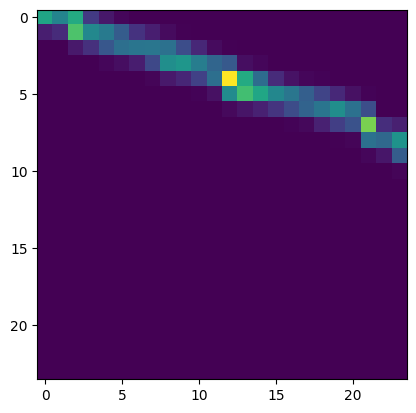

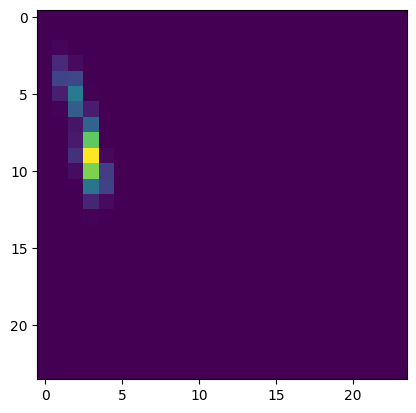

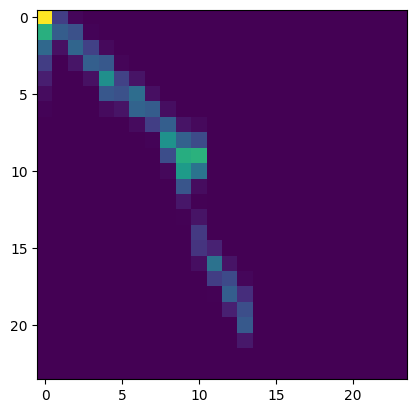

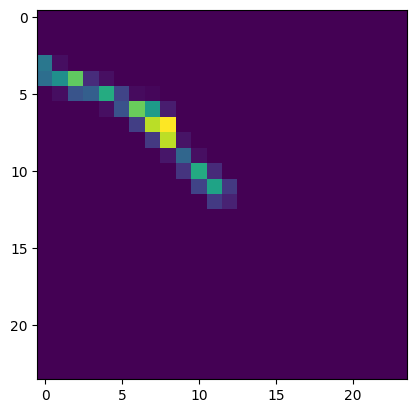

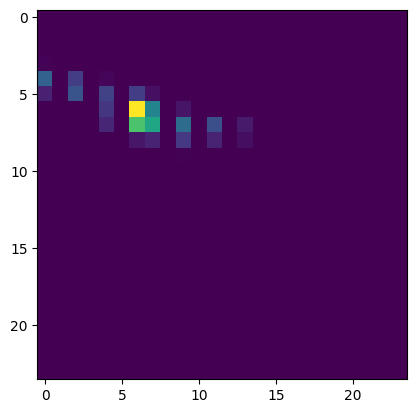

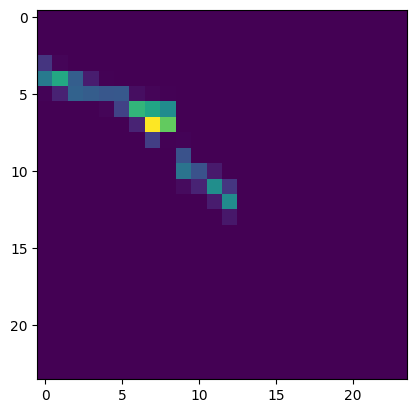

In [18]:
indexToView = 72838

print(y_pred[indexToView])

fig_startU, ax_startU = plt.subplots(1,1)
ax_startU.imshow(startGridU_calo_test[indexToView])

fig_startV, ax_startV = plt.subplots(1,1)
ax_startV.imshow(startGridV_calo_test[indexToView])

fig_startW, ax_startW = plt.subplots(1,1)
ax_startW.imshow(startGridW_calo_test[indexToView])
    
fig_endU, ax_endU = plt.subplots(1,1)
ax_endU.imshow(endGridU_calo_test[indexToView])

fig_enV, ax_endV = plt.subplots(1,1)
ax_endV.imshow(endGridV_calo_test[indexToView])

fig_endW, ax_endW = plt.subplots(1,1)
ax_endW.imshow(endGridW_calo_test[indexToView])